# Introduction

The purpose of this project is to determine whether or not living in a sunny area is correlated with better health outcomes in the United States. Four health outcomes will be examined: life expectancy, binge drinking prevalence, obesity prevalence, and depression prevalence. These four health outcomes will be compared to the average amount of daily sunlight received at either the state level or county level. These metrics will be compared using linear regression and the correlation coefficient will be calculated for each comparison.

My hypotheses are that daily sunlight will be positively correlated with life expectancy, and daily sunlight will be negatively correlated with binge drinking prevalence, obesity, and depression. Correlation coefficients with an absolute value below 0.5 will be considered weak, correlation coefficients with an absolute value between 0.5 and 0.7 will be considered moderate, and correlation coefficients with an absolute value of at least 0.7 will be considered strong.

In [1]:
# Import necessary Python libraries

import numpy as np
from datascience import *
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Data Collection

Daily sunlight data, life expectancy data, binge drinking data, obesity data, and depression data will be imported into this Jupyter notebook.

First up is daily sunlight data. This data was found at the following source:

https://wonder.cdc.gov/NASA-INSOLAR.html

Since there is data available at the county level for two of the health metrics (life expectancy and depression), but there is only data available at the state level for binge drinking and obesity, two sunlight tables will be used. The first will contain the average daily sunlight for each county in the United States and the second will contain the average daily sunlight for each state in the United States. In these tables, sunlight is measured in kJ/m^2 (kilojoules per square meter).

In [2]:
# Import sunlight data, grouped by county, downloaded from cdc.goc
# Source: https://wonder.cdc.gov/NASA-INSOLAR.html

SunlightDataCounty = Table.read_table('SunlightDataCounty.txt', sep="	").drop('Notes').relabel('Avg Daily Sunlight (KJ/m^2)','Average Daily Sunlight (kJ/m^2)')
SunlightDataCounty.show(5)

County,County Code,Average Daily Sunlight (kJ/m^2)
"Autauga County, AL",1001,17103.7
"Baldwin County, AL",1003,17660.6
"Barbour County, AL",1005,17315.1
"Bibb County, AL",1007,16904.9
"Blount County, AL",1009,16393.6


In [3]:
# Import sunlight data, grouped by state, downloaded from cdc.goc
# Source: https://wonder.cdc.gov/NASA-INSOLAR.html

SunlightDataState = Table.read_table('SunlightDataState.txt', sep="	").select('State','Avg Daily Sunlight (KJ/m^2)').relabel('Avg Daily Sunlight (KJ/m^2)','Average Daily Sunlight (kJ/m^2)')
SunlightDataState.show(5)

State,Average Daily Sunlight (kJ/m^2)
Alabama,16957.3
Arizona,19625.5
Arkansas,16498.6
California,19289.4
Colorado,17388.3


Next, life expectancy data will be imported. This data was found at the following source:

https://data.cdc.gov/NCHS/U-S-Life-Expectancy-at-Birth-by-State-and-Census-T/5h56-n989/about_data

Rows without any data relevant to this project are removed. Since this data is listed by Census tract, but I want the data to be listed by county, the data is grouped together by county and the average life expectancy for all the Census tracts in a given county is used as the life expectancy measurement for that county. Life expectancy is measured in years.

In [4]:
# Import life expectancy data, downloaded from cdc.gov
# Source: https://data.cdc.gov/NCHS/U-S-Life-Expectancy-at-Birth-by-State-and-Census-T/5h56-n989/about_data

LifeExpectancy = Table.read_table('LifeExpectancy.csv').select('County','Life Expectancy') # Import table and select relevant columns
LifeExpectancy = LifeExpectancy.where('Life Expectancy',are.above(0)).where('County',are.not_equal_to('(blank)')) # Get rid of rows without relevant data
LifeExpectancy = LifeExpectancy.group('County',np.mean).relabel('Life Expectancy mean','Average Life Expectancy (Years)') # Group data by county and fix label
LifeExpectancy.show(5)

County,Average Life Expectancy (Years)
"Abbeville County, SC",77.65
"Acadia Parish, LA",74.4455
"Accomack County, VA",76.8875
"Ada County, ID",79.9153
"Adair County, IA",78.1333


Next, binge drinking prevalence data will be imported. This data was found here:

https://www.cdc.gov/alcohol/data-stats.htm

This data is listed by state. The full state names are used in the sunlight data table, but the two letter state abbreviations are used in this binge drinking data table. In order for the tables to be joined together, which will happen later, the states in the binge drinking table must be changed to their full names. This is accomplished using a table with all the state names and their two letter abbreviations. This table was found here:

https://github.com/jasonong/List-of-US-States/blob/master/states.csv

The abbreviated state column in the binge drinking table was changed to the full state name column from this state table.

In this table, binge drinking is defined as: males that have had five or more drinks on one occasion and females that have had four or more drinks on one occasion, in the past 30 days.

In [5]:
# Import binge drinking prevalence data, downloaded from cdc.gov
# Source: https://www.cdc.gov/alcohol/data-stats.htm

BingeDrinking = Table.read_table('BingeDrinking.csv')
StateCodes = Table.read_table('states.csv') # Table with state names and their abbreviations, source/credit: https://github.com/jasonong/List-of-US-States/blob/master/states.csv
BingeDrinking = BingeDrinking.join('State',StateCodes,'Abbreviation').select('State_2','Prevalence') # Change state abbreviations to full names for combatibility with sunlight table
BingeDrinking = BingeDrinking.relabel('State_2','State').relabel('Prevalence','Binge Drinking Prevalence (%)') # Relabel columns for consistency
BingeDrinking.show(5)

State,Binge Drinking Prevalence (%)
Alaska,17.7
Alabama,13.7
Arkansas,13.9
Arizona,17.2
California,15.5


Next, obesity prevalence data will be imported. This data was found here:

https://www.cdc.gov/obesity/data/prevalence-maps.html

This data is listed by state. Luckily, this table already uses the full state names so they don't have to be changed. Obesity prevalence is defined as the percentage of adults with a BMI of at least 30.

In [6]:
# Import obesity prevalence data, downloaded from cdc.goc
# Source: https://www.cdc.gov/obesity/data/prevalence-maps.html

Obesity = Table.read_table('ObesityPrevalence.csv').select('State','Prevalence').relabel('Prevalence','Obesity Prevalence (%)') # Import table and change label
Obesity.show(5)

State,Obesity Prevalence (%)
Alabama,38.3
Alaska,32.1
Arizona,33.2
Arkansas,37.4
California,28.1


Finally, depression prevalence data will be imported. This data was found here:

https://stacks.cdc.gov/view/cdc/129404

This data is listed by county. The county codes will be used to join this table with the sunlight table later. Here, depression prevalence is defined as the estimated percentage of adults with a self-reported diagnosis of depression.

In [7]:
# Import depression prevalence data, downloaded from cdc.goc
# Source: https://stacks.cdc.gov/view/cdc/129404

Depression = Table.read_table('DepressionPrevalence.csv').select('CountyFIPS code','Crude Prevalence Estimate').relabel('CountyFIPS code','County Code').relabel('Crude Prevalence Estimate','Depression Prevalence (%)')
Depression.show(5)

County Code,Depression Prevalence (%)
1001,24.5
1003,24.6
1005,23.7
1007,24.8
1009,26.7


A function is defined to compare two columns in a table. This function will take in the name of a table and the names of two columns in that table as the input. The function will calculate the correlation coefficient between the two columns and use Seaborn to make a linear regression plot of the data in the two columns.

In [8]:
# Define function to compare 2 columns in a table
# Input: A table and the names of 2 columns in the table
# Output: The correlation coefficient, info about the correlation coefficient, and a regression plot that compares the two variables

def CompareColumns(table, x_column, y_column):
    print('\nComparison between '+x_column+' and '+y_column+':\n')
    
    x_values = table.column(x_column)
    y_values = table.column(y_column)
    x_values_std = (x_values - np.mean(x_values))/np.std(x_values) # Standarize x values
    y_values_std = (y_values - np.mean(y_values))/np.std(y_values) # Standarize y values
    corr_coeff = np.mean(x_values_std*y_values_std) # Calculate correlation coefficient
    
    # Determine strength of correlation
    if abs(corr_coeff) >= 0.7:
        corr_strength = 'strong'
    elif abs(corr_coeff) >= 0.5:
        corr_strength = 'moderate'
    else:
        corr_strength = 'weak'
    # Determine sign of the correlation coefficient
    if corr_coeff > 0:
        corr_sign = 'positive'
    elif corr_coeff < 0:
        corr_sign = 'negative'

    # Print results and create plot
    print('The correlation coefficient is:',corr_coeff)
    print('This is a',corr_strength,corr_sign,'correlation.\n')
    plot = sns.regplot(x = x_values, y = y_values, scatter_kws={'color': 'deepskyblue'}, line_kws = {'color': 'green'}) # Seaborn linear regression plot
    plot.set(xlabel = x_column, ylabel = y_column) # Add axis labels
    plt.show()

# Results

Now that all the data has been imported and the comparison function has been defined, the four health metrics can be compared to the sunlight data.

County,County Code,Average Daily Sunlight (kJ/m^2),Average Life Expectancy (Years)
"Abbeville County, SC",45001,17119.6,77.65
"Acadia Parish, LA",22001,17400.8,74.4455
"Accomack County, VA",51001,17486.2,76.8875
"Ada County, ID",16001,16625.1,79.9153
"Adair County, IA",19001,14874.8,78.1333



Comparison between Average Daily Sunlight (kJ/m^2) and Average Life Expectancy (Years):

The correlation coefficient is: -0.154996371968
This is a weak negative correlation.



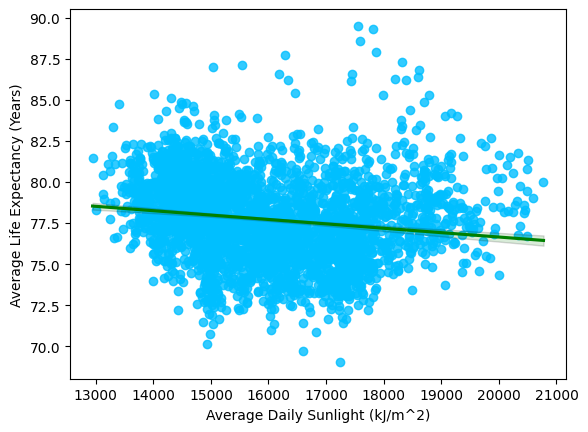

In [9]:
# Compare sunlight data to life expectancy

SunlightAndLifeExpectancy = SunlightDataCounty.join('County',LifeExpectancy,'County')
SunlightAndLifeExpectancy.show(5)
CompareColumns(SunlightAndLifeExpectancy, "Average Daily Sunlight (kJ/m^2)", "Average Life Expectancy (Years)")

Average daily sunlight had a weak negative correlation to life expectancy. This was unexpected! I expected a positive correlation. There doesn't seem to be any clear pattern in this data; it looks like random noise.

State,Average Daily Sunlight (kJ/m^2),Binge Drinking Prevalence (%)
Alabama,16957.3,13.7
Arizona,19625.5,17.2
Arkansas,16498.6,13.9
California,19289.4,15.5
Colorado,17388.3,19.5



Comparison between Average Daily Sunlight (kJ/m^2) and Binge Drinking Prevalence (%):

The correlation coefficient is: -0.380921146756
This is a weak negative correlation.



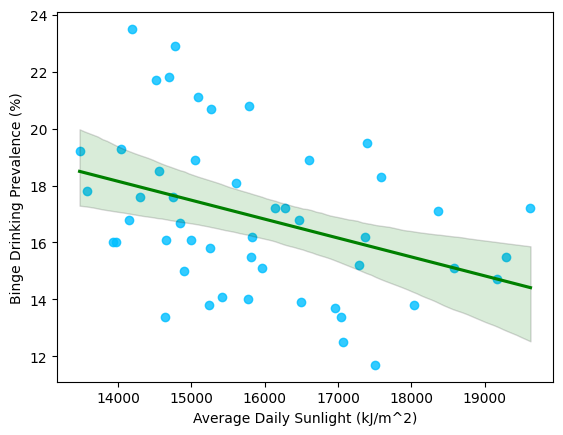

In [10]:
# Compare sunlight data to binge drinking prevalence

SunlightAndDrinking = SunlightDataState.join('State',BingeDrinking,'State')
SunlightAndDrinking.show(5)
CompareColumns(SunlightAndDrinking, "Average Daily Sunlight (kJ/m^2)", "Binge Drinking Prevalence (%)")

The correlation of average daily sunlight to binge drinking prevalence is more noticeable. Although this is still considered a weak correlation, it appears that sunlight could have at least some effect on whether or not people choose to drink alcohol.

State,Average Daily Sunlight (kJ/m^2),Obesity Prevalence (%)
Alabama,16957.3,38.3
Arizona,19625.5,33.2
Arkansas,16498.6,37.4
California,19289.4,28.1
Colorado,17388.3,25



Comparison between Average Daily Sunlight (kJ/m^2) and Obesity Prevalence (%):

The correlation coefficient is: 0.0520827551137
This is a weak positive correlation.



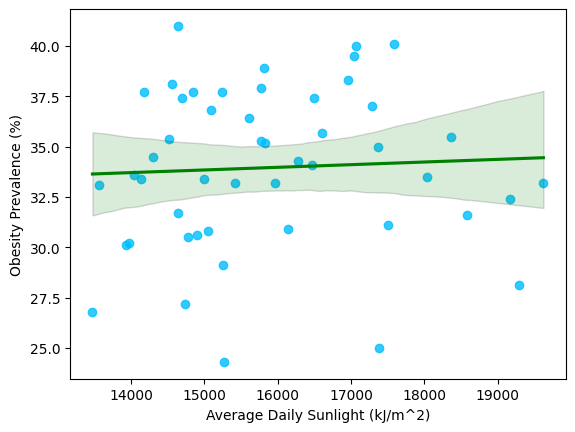

In [11]:
# Compare sunlight data to obesity prevalence

SunlightAndObesity = SunlightDataState.join('State',Obesity,'State')
SunlightAndObesity.show(5)
CompareColumns(SunlightAndObesity, "Average Daily Sunlight (kJ/m^2)", "Obesity Prevalence (%)")

A negative correlation was expected for daily sunlight and obesity, but a very weak positive correlation was found instead, so this was also unexpected. There doesn't really seem to be any pattern in the data.

County Code,County,Average Daily Sunlight (kJ/m^2),Depression Prevalence (%)
1001,"Autauga County, AL",17103.7,24.5
1003,"Baldwin County, AL",17660.6,24.6
1005,"Barbour County, AL",17315.1,23.7
1007,"Bibb County, AL",16904.9,24.8
1009,"Blount County, AL",16393.6,26.7



Comparison between Average Daily Sunlight (kJ/m^2) and Depression Prevalence (%):

The correlation coefficient is: -0.087915496293
This is a weak negative correlation.



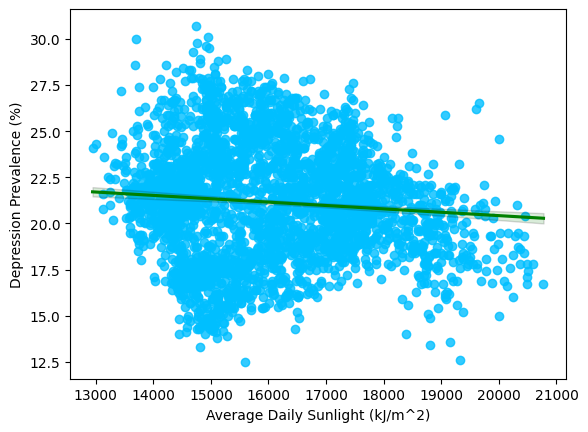

In [12]:
# Compare sunlight data to depression prevalence

SunlightAndDepression = SunlightDataCounty.join('County Code',Depression,'County Code')
SunlightAndDepression.show(5)
CompareColumns(SunlightAndDepression, "Average Daily Sunlight (kJ/m^2)", "Depression Prevalence (%)")

A negative correlation was expected for daily sunlight and depression, and a negative correlation was found, but it is pretty weak. The counties with the highest rates of depression seem to have relatively low levels of sunlight, however.

State,Obesity Prevalence (%),Binge Drinking Prevalence (%)
Alabama,38.3,13.7
Alaska,32.1,17.7
Arizona,33.2,17.2
Arkansas,37.4,13.9
California,28.1,15.5



Comparison between Binge Drinking Prevalence (%) and Obesity Prevalence (%):

The correlation coefficient is: -0.201976818678
This is a weak negative correlation.



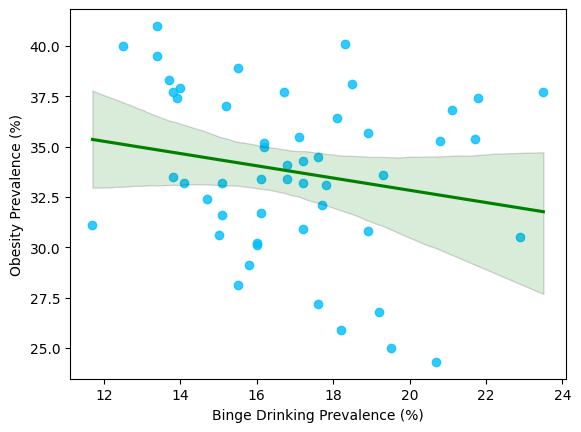

In [13]:
# Just for fun: comparing obesity and binge drinking

DrinkingAndObesity = Obesity.join('State',BingeDrinking,'State')
DrinkingAndObesity.show(5)
CompareColumns(DrinkingAndObesity,'Binge Drinking Prevalence (%)','Obesity Prevalence (%)')

Just for fun, binge drinking prevalence and obesity prevalence were compared. Apparently, binge drinking alcohol makes you skinnier! This shows that correlation doesn't always mean causation.

# Conclusion

None of the health metrics examined had a moderate or strong correlation with sunlight. The strongest correlation was seen between sunlight and binge drinking, where it appears that more daily sunlight is correlated with less binge drinking, but the correlation coefficient was only about -0.38. I was hoping to find evidence to support my hypothesis that living in a sunnier area would lead to better health outcomes, but this evidence was not found!